# 1. 메모리 변수 제거

In [1]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

# 2. 사용 패키지

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rc('font', family = 'Malgun Gothic') # WINDOWS
plt.rc('font', family = 'AppleGothic') # MAC
plt.rc('axes', unicode_minus = False)
import warnings
warnings.filterwarnings('ignore')

# 3. 데이터 로드

In [3]:
train = pd.read_csv('data/train_pre.csv')

# 4. 데이터 정보

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   년               1205 non-null   int64  
 2   월               1205 non-null   int64  
 3   일               1205 non-null   int64  
 4   요일              1205 non-null   int64  
 5   휴일전날            1205 non-null   int64  
 6   본사정원수           1205 non-null   int64  
 7   본사휴가자수          1205 non-null   int64  
 8   본사출장자수          1205 non-null   int64  
 9   본사시간외근무명령서승인건수  1205 non-null   int64  
 10  현본사소속재택근무자수     1205 non-null   int64  
 11  식사가능자수          1205 non-null   int64  
 12  중식계             1205 non-null   int64  
 13  석식계             1205 non-null   int64  
 14  중식참여율           1205 non-null   float64
 15  석식참여율           1205 non-null   float64
 16  체감온도(중식)        1205 non-null   float64
 17  불쾌지수(중식)        1205 non-null   i

# 5. 모델 평가

## 1) 데이터 분할

In [5]:
from sklearn.model_selection import train_test_split
X = train.drop(['일자', '중식계', '석식계', '중식참여율', '석식참여율'], axis = 1)
y = train[['중식계', '석식계']]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3, random_state = 2021)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((843, 19), (362, 19), (843, 2), (362, 2))

## 2) Standard Scaler

In [7]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

## 3) Random Forest Regression

### (1) 교차검증

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
rfr = RandomForestRegressor(random_state = 2021)
scores = cross_val_score(
    rfr, X_train, y_train, cv = 5, n_jobs = -1,
    scoring = 'neg_mean_squared_error'
)
print('RMSE : {}'.format(np.sqrt(-scores)))
print('RMSE평균 : {}'.format(np.sqrt(-scores.mean())))

RMSE : [94.51223771 85.02233721 94.85365883 94.30588492 91.10598015]
RMSE평균 : 92.03529436609418


### (2) 그리드 탐색

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor(random_state = 2021)
parameters = {
    'n_estimators' : [100, 200, 300],
    'max_features' : [10, 11, 12],
    'min_samples_leaf' : [1, 2, 3]
}
grds = GridSearchCV(rfr, param_grid = parameters, cv = 3, n_jobs = -1)
grds.fit(X_train, y_train)
print('최적 하이퍼파라미터 : ', grds.best_params_)
print('최적 하이퍼파라미터 RMSE : {:.4f}'.format(np.sqrt(grds.best_score_)))

최적 하이퍼파라미터 :  {'max_features': 11, 'min_samples_leaf': 2, 'n_estimators': 200}
최적 하이퍼파라미터 RMSE : 0.8376


### (3) 임의 탐색

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
rfr = RandomForestRegressor(random_state = 2021)
parameters = {
    'n_estimators' : stats.randint(100, 500),
    'max_features' : stats.randint(7, 8),
    'min_samples_leaf' : stats.randint(1, 2)
}
rand = RandomizedSearchCV(rfr, param_distributions = parameters, n_iter = 10, cv = 3, n_jobs = -1, random_state = 2021)
rand.fit(X_train, y_train)
print('최적 하이퍼파라미터 : ', rand.best_params_)
print('최적 하이퍼파라미터 RMSE : {:.4f}'.format(np.sqrt(rand.best_score_)))

최적 하이퍼파라미터 :  {'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 209}
최적 하이퍼파라미터 RMSE : 0.8373


# 5. 모델 실행

## 1) 첫 번째 모델
- Default

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rfr = RandomForestRegressor(random_state = 2021)
rfr.fit(X_train, y_train)
pred_1 = rfr.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred_1))

92.13635436224807

## 2) 두 번째 모델
- 'max_features': 11, 'min_samples_leaf': 2, 'n_estimators': 200

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rfr = RandomForestRegressor(
    max_features = 11, min_samples_leaf = 2,
    n_estimators = 200, random_state = 2021
)
rfr.fit(X_train, y_train)
pred_2 = rfr.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred_2))

90.15506577044027

## 3) 세 번째 모델
- 'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 209

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rfr = RandomForestRegressor(max_features = 7, min_samples_leaf = 1, n_estimators = 209, random_state = 2021)
rfr.fit(X_train, y_train)
pred_3 = rfr.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred_3))

88.37604769910392

## 4) 네 번째 모델
- 'n_estimators' = 800, 'max_depth' = 20, 'bootstrap' = True

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rfr = RandomForestRegressor(n_estimators = 800, max_depth = 20, bootstrap = True, random_state = 2021)
rfr.fit(X_train, y_train)
pred_4 = rfr.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred_4))

91.71939918997622

# 6. 모델 검증

## 1) ANOVA
- R²(결정계수) : RSS / TSS = 1 - SSE / TSS
- TSS : (y - y평균)²
- RSS : (y예측 - y평균)²
- SSE : (y예측 - y)²

In [15]:
from sklearn.metrics import r2_score
print('R²값(1) : %.3f' % r2_score(y_test, pred_1)) # 첫 번째 모델
print('R²값(2) : %.3f' % r2_score(y_test, pred_2)) # 두 번째 모델
print('R²값(3) : %.3f' % r2_score(y_test, pred_3)) # 세 번째 모델
print('R²값(4) : %.3f' % r2_score(y_test, pred_4)) # 네 번째 모델

R²값(1) : 0.692
R²값(2) : 0.698
R²값(3) : 0.705
R²값(4) : 0.692


## 2) 비교

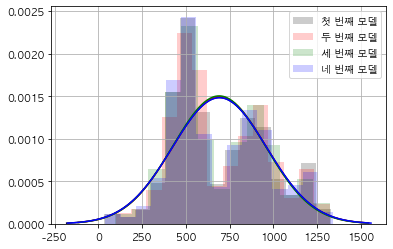

In [16]:
sns.distplot(pred_1, kde = False, fit = stats.norm, hist_kws = {'color' : 'k', 'alpha' : 0.2}, fit_kws = {'color' : 'k'}, label = '첫 번째 모델')
sns.distplot(pred_2, kde = False, fit = stats.norm, hist_kws = {'color' : 'r', 'alpha' : 0.2}, fit_kws = {'color' : 'r'}, label = '두 번째 모델')
sns.distplot(pred_3, kde = False, fit = stats.norm, hist_kws = {'color' : 'g', 'alpha' : 0.2}, fit_kws = {'color' : 'g'}, label = '세 번째 모델')
sns.distplot(pred_4, kde = False, fit = stats.norm, hist_kws = {'color' : 'b', 'alpha' : 0.2}, fit_kws = {'color' : 'b'}, label = '네 번째 모델')
plt.legend()
plt.grid()
plt.show()

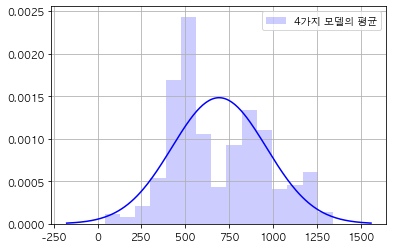

In [17]:
mean = (pred_1 + pred_2 + pred_3 + pred_4) / 4
sns.distplot(pred_4, kde = False, fit = stats.norm, hist_kws = {'color' : 'b', 'alpha' : 0.2}, fit_kws = {'color' : 'b'}, label = '4가지 모델의 평균')
plt.legend()
plt.grid()
plt.show()